In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!pip install datasets
!pip install apache_beam mwparserfromhell
!pip install googletrans==3.1.0a0
!pip install nltk
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dill-0.3.5.1-py2.py3-none-any.whl (95 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.1.1
    Uninstalling dill-0.3.1.1:
      Successfully uninstalled dill-0.3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.41.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dill-0.3.1.1-py3-none-any.whl
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.13 requires dill>=0.3.5.1, but you have dill 0.3.1.1 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset
import nltk
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertModel

bert_type = "bert-base-cased"

class trainSentenceDataset(Dataset):
  def __init__(self, is_val=False):
    wiki_dataset=None
    if is_val:
      wiki_dataset = load_dataset("wikipedia", "20220301.simple", split='train[-2000:]')
    else:
      wiki_dataset = load_dataset("wikipedia", "20220301.simple", split='train[:1000]')

    print(len(wiki_dataset))
    texts = [article['text'] for article in wiki_dataset]
    nltk.download('punkt')
    self.tokenizer = BertTokenizer.from_pretrained(bert_type)
    self.sentences = [sentence for text in texts for sentence in nltk.tokenize.sent_tokenize(text)[:-1]]
    self.next_sentences = [next_sentence for text in texts for next_sentence in nltk.tokenize.sent_tokenize(text)[1:]]

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self, index):
    tokenized_sentences = self.tokenize(self.sentences[index])
    tokenized_next_sentences = self.tokenize(self.next_sentences[index])
    tensor1 = torch.stack(
        (tokenized_sentences['input_ids'], tokenized_sentences['token_type_ids'], tokenized_sentences['attention_mask']), 0
    )
    tensor2 = torch.stack(
        (tokenized_sentences['input_ids'], tokenized_sentences['token_type_ids'], tokenized_sentences['attention_mask']), 0
    )

    ret_tensor = torch.stack((tensor1, tensor2), 0)
    return ret_tensor

  def tokenize(self, sentences):
    return self.tokenizer(sentences, return_tensors="pt", padding="max_length", truncation=True)

trainset = trainSentenceDataset(is_val=False)
valset = trainSentenceDataset(is_val=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1000


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2000


In [ ]:
print(len(trainset))
print(len(valset))

torch.Size([2, 3, 67, 512])
37141
10810


In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def get(self):
      return self.avg
    
    def get_count(self):
      return self.count

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
import gc

class SentCimCLR(nn.Module):
  def __init__(self):
    super().__init__()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.temperature = 0.5
    self.projection_dim = 128
    self.latent_dim = 768
    self.model = BertModel.from_pretrained(bert_type, use_cache=False)
    self.proj = nn.Sequential(
        nn.Linear(self.latent_dim, self.projection_dim, bias=False),
        nn.BatchNorm1d(self.projection_dim),
        nn.ReLU(inplace=True),
        nn.Linear(self.projection_dim, self.projection_dim, bias=False),
        nn.BatchNorm1d(self.projection_dim, affine=False)
    ).to(self.device)
  
  def encode(self, input):
    input_ids, token_type_ids, attention_mask = input
    input_ids, token_type_ids, attention_mask = input_ids.to(self.device), \
                  token_type_ids.to(self.device), attention_mask.to(self.device)
    model = self.model.to(self.device)
    model.eval()
    with torch.no_grad():
      output = self.model(input_ids=input_ids, token_type_ids=token_type_ids, 
                          attention_mask=attention_mask)
      pooler_output = output.pooler_output
    return pooler_output

  def get_rep(self, x):
    h = self.encode(x)
    h = h.to(self.device)
    z = self.proj(h).to(self.device)
    z = torch.nn.functional.normalize(z).to(self.device)

    return z

  def forward(self, sentences):
    xi, xj = sentences
    zi, zj = self.get_rep(xi), self.get_rep(xj)
    n = sentences[0][0].shape[0]

    zis = [zi]
    zjs = [zj]

    z1 = torch.cat((zi,zj), dim=0).to(self.device)
    z2 = torch.cat(zis + zjs, dim=0).to(self.device)


    sim_matrix = torch.mm(z1, z2.t()).to(self.device)
    sim_matrix = sim_matrix / self.temperature

    sim_matrix[torch.arange(n), torch.arange(n)]  = -float('inf')
    sim_matrix[torch.arange(n, 2*n), torch.arange(n, 2*n)] = -float('inf')

    targets = torch.cat((torch.arange(n, 2*n),
                          torch.arange(n)), dim=0)
    targets = targets.to(sim_matrix.get_device()).long()

    loss = F.cross_entropy(sim_matrix, targets, reduction='sum')
    loss = loss / n
  
    return dict(Loss=loss)


In [ ]:
class ModelState:
  def __init__(self, model):
    self.model_state_dicts = [model.state_dict()]
    self.train_losses = []
    self.val_losses = []
    self.curr_epoch = 0

  def update(self, model, train_loss, val_loss):
    self.model_state_dicts.append(model.state_dict())
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.curr_epoch += 1

  def load_state_dict(self, model, idx=-1): # idx = epoch + 1
    if idx >= len(self.model_state_dicts):
      idx = -1
    model.load_state_dict(self.model_state_dicts[idx])

  def get_epoch(self):
    return self.curr_epoch

  def get_train_losses(self):
    return self.train_losses

  def get_val_losses(self):
    return self.val_losses

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


15087
11959
train set length: 37141, validation set length: 10810
Using device: cuda:0


0it [00:00, ?it/s]

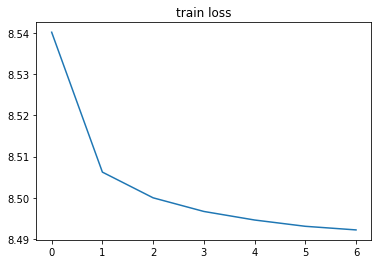

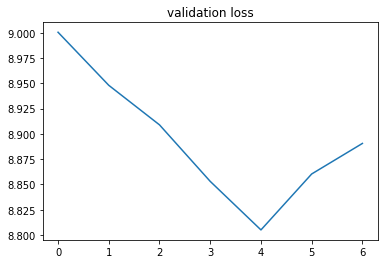

Finished Training


In [ ]:
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle

model = SentCimCLR()

try:
  with open('/content/drive/My Drive/model_state.dump', 'rb') as f:
      model_state = pickle.load(f)

  model_state.load_state_dict(model)
  start_epoch = model_state.get_epoch()
  train_loss_values = model_state.get_train_losses()
  val_loss_values = model_state.get_val_losses()

except (OSError, IOError) as e:
  model_state = ModelState(model)
  pickle.dump(model_state, open('/content/drive/My Drive/model_state.dump', 'wb'))
  start_epoch = 0
  train_loss_values = []
  val_loss_values = []


# train_val_seperator = len(dataset) * 2 / 3 
# trainset, valset = dataset
# trainset, valset = train_test_split(dataset, test_size=0.33, shuffle=False)
batch_size = 256

print(f'train set length: {len(trainset)}, validation set length: {len(valset)}')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 7

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


for epoch in tqdm(range(start_epoch, num_epochs)):
    print(f'Beginning epoch #{epoch}')

    torch.cuda.empty_cache()

    model.train()
    running_train_loss = AverageMeter()
    for data in tqdm(trainloader, leave=False):
      data = data.to(device)
      data = data.squeeze()
      data = data.permute(1,2,0,3)
      optimizer.zero_grad()
      loss = model(data)['Loss']

      loss.backward()
      optimizer.step()

      running_train_loss.update(loss.item())
      torch.cuda.empty_cache()

    print(f'train loss for epoch i: {epoch} is {running_train_loss.get()}')
    train_loss_values.append(running_train_loss.get())

    torch.cuda.empty_cache()

    model.eval()
    running_val_loss = AverageMeter()
    for data in tqdm(valloader, leave=False):
      data = data.to(device)
      data = data.squeeze()
      data = data.permute(1,2,0,3)
      with torch.no_grad():
        loss = model(data)['Loss']

      running_val_loss.update(loss.item())
      torch.cuda.empty_cache()
  
    print(f'validation loss for epoch i: {epoch} is {running_val_loss.get()}') 
    val_loss_values.append(running_val_loss.get())

    #Save model state for future use
    model_state.update(model, running_train_loss.get(), running_val_loss.get())
    pickle.dump(model_state, open('/content/drive/My Drive/model_state.dump', 'wb'))


val_loss_values = [val_loss for i, val_loss in enumerate(val_loss_values) if i % 2 == 0]
train_loss_values = [train_loss for i, train_loss in enumerate(train_loss_values) if i % 2 == 0]
plt.title("train loss")
plt.plot(train_loss_values)
plt.show()

plt.title("validation loss")
plt.plot(val_loss_values)
plt.show()


print(f'Finished Training')


In [ ]:
val_loss_values = np.array(val_loss_values)
best_model_state_index = val_loss_values.argmin() + 1
print(f'loading model state before epoch: {best_model_state_index}')
model_state.load_state_dict(model, best_model_state_index)

del model_state
torch.cuda.empty_cache()

loading model state before epoch: 5


In [ ]:
from collections import defaultdict 

class testSentenceDataset(Dataset):
  def __init__(self, size=1000, shift=0):
    wiki_dataset = load_dataset("wikipedia", "20220301.simple", split=f'train[{1000 + shift}:{1000 + shift + size}]')
    texts_and_titles = [(article['text'], article['title']) for article in wiki_dataset]
    texts, titles = list(zip(*texts_and_titles))
    nltk.download('punkt')
    self.tokenizer = BertTokenizer.from_pretrained(bert_type)
    sentences_and_titles = [(sentence, titles[i]) for i, text in enumerate(texts) for sentence in nltk.tokenize.sent_tokenize(text)[:-1]]
    self.titles = set()
    self.titles_sentences_dict = defaultdict(list)
    for sentence, title in sentences_and_titles:
      self.titles.add(title)
      self.titles_sentences_dict[title].append(sentence)
    for title, sentences in self.titles_sentences_dict.items():
      tokenized_sentences = self.tokenize(sentences)
      ret_tensor = torch.stack(
        (tokenized_sentences['input_ids'], tokenized_sentences['token_type_ids'], tokenized_sentences['attention_mask']), 0
      )
      self.titles_sentences_dict[title] = ret_tensor

    self.sentences, self.corr_titles = list(zip(*sentences_and_titles))

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self, index):
    tokenized_sentences = self.tokenize(self.sentences[index])
    ret_tensor = torch.stack(
        (tokenized_sentences['input_ids'], tokenized_sentences['token_type_ids'], tokenized_sentences['attention_mask']), 0
    )
  
    return ret_tensor, self.sentences[index], self.corr_titles[index]

  def tokenize(self, sentences):
    return self.tokenizer(sentences, return_tensors="pt", padding="max_length", truncation=True)

  def get_tokenized_sentences_by_title(self):
    return self.titles_sentences_dict

# testset = testSentenceDataset(5,52)
# len(testset)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


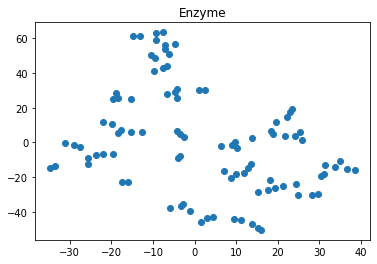

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


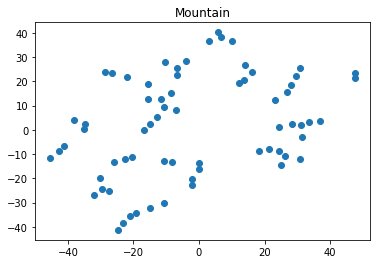

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


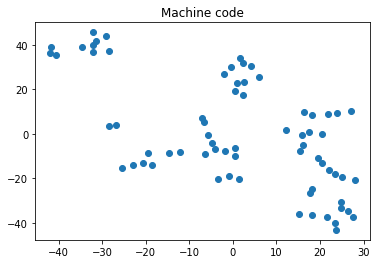

In [ ]:
from sklearn.manifold import TSNE

torch.cuda.empty_cache()

model.eval()
for j in range(3):
  testset = testSentenceDataset(1, j + 6)
  for i, (title, sentences) in enumerate(testset.get_tokenized_sentences_by_title().items()):
    with torch.no_grad():
      rep_sentencs = model.get_rep(sentences).cpu().detach().numpy()
    reduced_dim_rep = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(rep_sentencs)
    plt.scatter(reduced_dim_rep[:,0], reduced_dim_rep[:,1])
  
  plt.title(title)
  plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


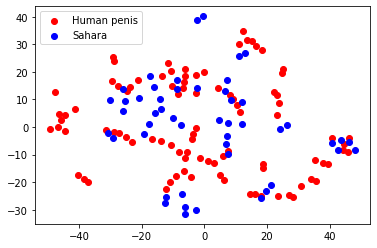

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


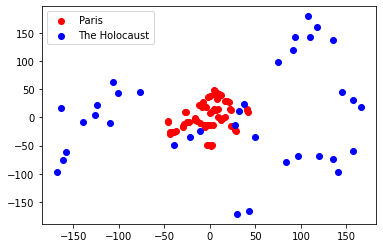

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


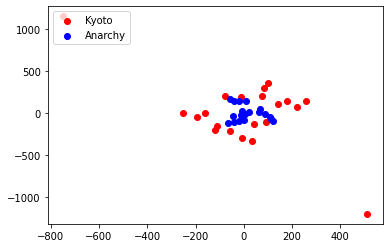

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


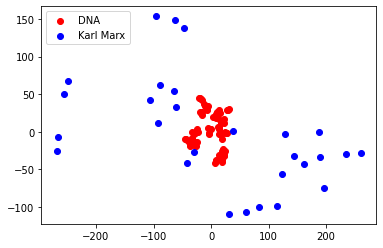

In [ ]:
torch.cuda.empty_cache()

cdict = {0: 'red', 1: 'blue', 2: 'green', 3:'purple', 4:'orange'}

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)

for j in range(4):
  testset = testSentenceDataset(2, 200 + j*2)
  for i, (title, sentences) in enumerate(testset.get_tokenized_sentences_by_title().items()):
    with torch.no_grad():
      rep_sentencs = model.get_rep(sentences).cpu().detach().numpy()
    reduced_dim_rep = tsne.fit_transform(rep_sentencs)
    plt.scatter(reduced_dim_rep[:,0], reduced_dim_rep[:,1], c=cdict[i], label=title)

  plt.legend(loc='upper left')
  plt.show()





In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

torch.cuda.empty_cache()

np.random.seed(55)
nbrs = NearestNeighbors(n_neighbors=5)


def pairwise(iterable):
    a = iter(iterable)
    return zip(a, a)

average_precentile = AverageMeter()
precentiles = []
testset = testSentenceDataset(1000)
for (_, sentences1), (_, sentences2) in tqdm(pairwise(testset.get_tokenized_sentences_by_title().items())):
  torch.cuda.empty_cache()
  with torch.no_grad():
    if len(sentences1[0]) < 10 or len(sentences1[0]) > 255:
      continue
    rep_sentences1 = model.get_rep(sentences1).cpu().detach().numpy()
    # print(rep_sentences1.shape)
    temp_rep_sentences2 = model.get_rep(sentences2).cpu().detach().numpy()
    random_idx = np.random.randint(len(temp_rep_sentences2), size=1).item()
    rep_sentences2 = temp_rep_sentences2[random_idx:random_idx+1]
    # print(rep_sentences2.shape)
    rep_sentences = np.concatenate((rep_sentences1, rep_sentences2), axis=0)
    # print(rep_sentences.shape)
    nbrs.fit(rep_sentences)
    distances, indices = nbrs.kneighbors(rep_sentences)
    distances_mean = distances.mean(axis=1)
    curr_precentile = sum(np.abs(distances_mean) <= distances_mean[-1]) * 100 / float(len(distances_mean))
    precentiles.append(curr_precentile)
    # print(curr_precentile)
    # average_precentile.update(curr_precentile)

precentiles = np.array(precentiles)
precentiles_mean = precentiles.mean()
precentiles_median = np.median(precentiles)
print(f'average precentile:{precentiles_mean}, median precentile:{precentiles_median}')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0it [00:00, ?it/s]

average precentile:88.09183136560641, average precentile:96.42857142857143
